# Raport końcowy i wdrożenie modelu predykcyjnego plonów pszenicy ozimej

W tym notebooku prezentujemy końcową walidację, rekomendacje oraz wdrożenie systemu predykcyjnego plonów pszenicy ozimej na podstawie zintegrowanego panelu agroekonomicznego i klasteryzacji regionalnej.
Podsumowujemy efekty analizy, przedstawiamy rekomendacje nawozowe dla województw oraz opisujemy sposób wdrożenia modelu jako API.

---

## Podsumowanie wyników z Notebooka 03

- Zbudowano model Random Forest na pełnym panelu agroekonomicznym z klastrami finansowymi i pogodowymi.
- Model osiągnął bardzo dobre parametry walidacyjne:
  - **MAE:** 2.56 dt/ha
  - **RMSE:** 3.57 dt/ha
  - **R²:** 0.77
- Przeprowadzono optymalizację dawek nawozów dla każdego województwa osobno, uzyskując zróżnicowane rekomendacje zależne od warunków lokalnych.
- Wygenerowano analizę ekonomiczną dla każdej strategii nawożenia.

---

## Zakres Notebooka 04

- Walidacja końcowa modelu i prezentacja metryk na pełnym panelu
- Generowanie i prezentacja rekomendacji nawozowych oraz analizy ekonomicznej dla wszystkich województw
- Przykłady użycia modelu w API (FastAPI) oraz instrukcja wdrożenia na Azure
- Podsumowanie projektu, wnioski praktyczne i propozycje dalszego rozwoju

In [1]:
# Import niezbędnych bibliotek
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
import time
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import pandas as pd
import os
import uvicorn
import asyncio

# Ustawienia wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(font_scale=1.1)

# Ścieżki do katalogów
SCIEZKA_DANYCH = Path("../data")
SCIEZKA_PROCESSED = SCIEZKA_DANYCH / "processed"
SCIEZKA_MODELI = Path("../models")
SCIEZKA_WYKRESOW = Path("../reports/visualizations")
SCIEZKA_RAPORTOW = Path("../reports")

## 1. Walidacja modelu i automatyczna kontrola jakości

In [2]:
# Funkcja standaryzacji nazw województw (spójność z poprzednimi notebookami)
def standaryzuj_nazwe_wojewodztwa(nazwa):
    zamienniki = {'ą':'a', 'ć':'c', 'ę':'e', 'ł':'l', 'ń':'n',
                 'ó':'o', 'ś':'s', 'ź':'z', 'ż':'z', ' ':''}
    for znak, zamiennik in zamienniki.items():
        nazwa = nazwa.lower().replace(znak, zamiennik)
    return nazwa.upper().replace('-','')

# Wczytanie danych
print("Wczytywanie danych...")
df = pd.read_csv(SCIEZKA_PROCESSED / "panel_agroekonomiczny.csv")
df_klastry = pd.read_csv(SCIEZKA_PROCESSED / "dane_z_klastrami.csv")

# Standaryzacja nazw
df['wojewodztwo_std'] = df['wojewodztwo'].apply(standaryzuj_nazwe_wojewodztwa)

# Wczytanie modelu
print("Wczytywanie modelu...")
model = joblib.load(SCIEZKA_MODELI / "rf_model_plonow.pkl")
print(f"Wczytano model: {type(model)} z {model.n_estimators} drzewami")

Wczytywanie danych...
Wczytywanie modelu...
Wczytano model: <class 'sklearn.ensemble._forest.RandomForestRegressor'> z 100 drzewami


### 1.1 Przygotowanie danych do walidacji

In [3]:
# Łączenie danych z klastrami
df_full = df.merge(
    df_klastry[['wojewodztwo_std', 'Klaster_Finansowy', 'Klaster_Pogodowy']],
    on='wojewodztwo_std',
    how='left'
)

# Wybór cech - identycznie jak w modelu z Notebooka 03
features = [
    'Nawożenie N [kg/ha]',
    'Nawożenie P [kg/ha]',
    'Nawożenie K [kg/ha]',
    'Średnia temperatura [°C]',
    'Suma opadów [mm]',
    'Klaster_Finansowy',
    'Klaster_Pogodowy'
]

# Usunięcie wierszy z brakującymi wartościami
df_clean = df_full.dropna(subset=features + ['Plon [dt/ha]'])

# Przygotowanie danych
X = df_clean[features]
y = df_clean['Plon [dt/ha]']

# Predykcja na całym zbiorze
y_pred = model.predict(X)

### 1.2 Ewaluacja modelu

Metryki modelu na pełnym zbiorze danych:
MAE: 2.56 dt/ha
RMSE: 3.57 dt/ha
R²: 0.77


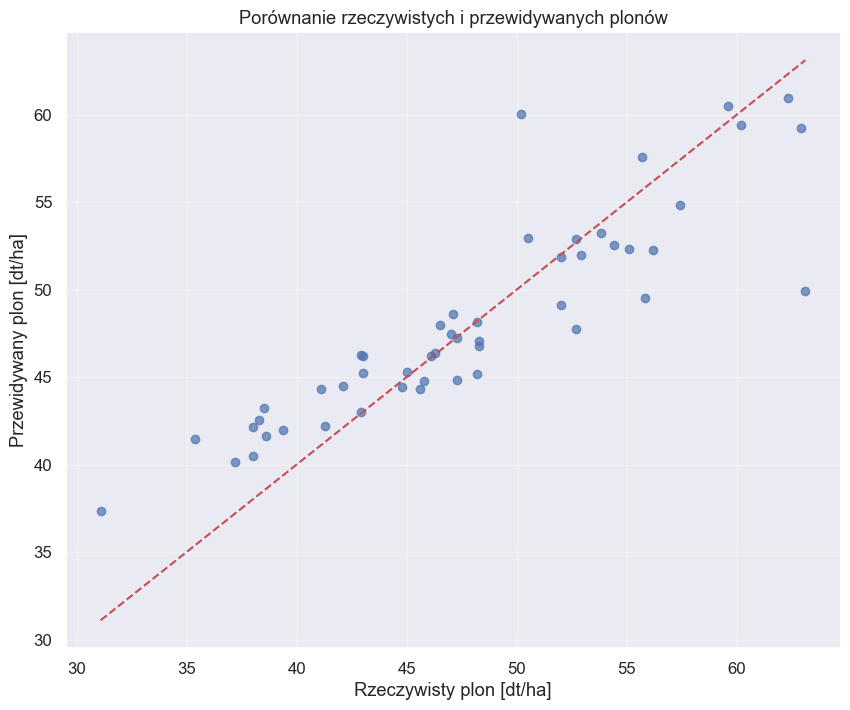

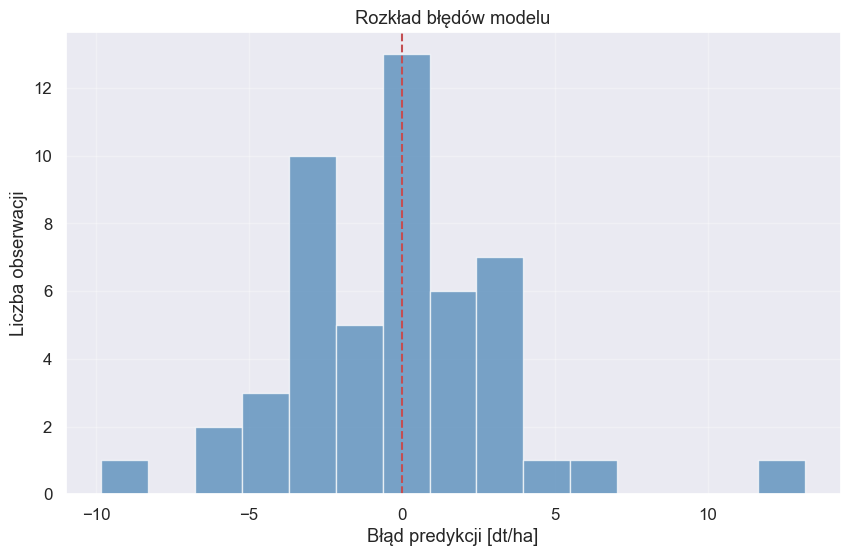

In [4]:
# Obliczenie metryk
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"Metryki modelu na pełnym zbiorze danych:")
print(f"MAE: {mae:.2f} dt/ha")
print(f"RMSE: {rmse:.2f} dt/ha")
print(f"R²: {r2:.2f}")

# Porównanie predykcji z wartościami rzeczywistymi
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Rzeczywisty plon [dt/ha]')
plt.ylabel('Przewidywany plon [dt/ha]')
plt.title('Porównanie rzeczywistych i przewidywanych plonów')
plt.grid(True, alpha=0.3)
plt.savefig(SCIEZKA_WYKRESOW / "walidacja_predykcje_vs_rzeczywiste.png", dpi=300, bbox_inches="tight")
plt.show()

# Histogram błędów
errors = y - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=15, alpha=0.7, color='steelblue')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Błąd predykcji [dt/ha]')
plt.ylabel('Liczba obserwacji')
plt.title('Rozkład błędów modelu')
plt.grid(True, alpha=0.3)
plt.savefig(SCIEZKA_WYKRESOW / "walidacja_histogram_bledow.png", dpi=300, bbox_inches="tight")
plt.show()


### 1.3. Analiza przypadków testowych

In [5]:
# Przygotowanie tabeli z wynikami walidacji
df_validation = df_clean[['wojewodztwo', 'rok', 'Plon [dt/ha]']].copy()
df_validation['Przewidywany plon [dt/ha]'] = y_pred
df_validation['Błąd bezwzględny [dt/ha]'] = np.abs(df_validation['Plon [dt/ha]'] - df_validation['Przewidywany plon [dt/ha]'])
df_validation['Błąd procentowy [%]'] = 100 * df_validation['Błąd bezwzględny [dt/ha]'] / df_validation['Plon [dt/ha]']

# TOP 5 najlepszych i najgorszych predykcji
print("\nTOP 5 najlepszych predykcji:")
print(df_validation.sort_values('Błąd bezwzględny [dt/ha]').head(5).round(2))

print("\nTOP 5 najgorszych predykcji:")
print(df_validation.sort_values('Błąd bezwzględny [dt/ha]', ascending=False).head(5).round(2))

# Zapis wyników walidacji
df_validation.to_csv(SCIEZKA_PROCESSED / "wyniki_walidacji.csv", index=False)
print(f"\nWyniki walidacji zapisano w: {SCIEZKA_PROCESSED / 'wyniki_walidacji.csv'}")


TOP 5 najlepszych predykcji:
            wojewodztwo   rok  Plon [dt/ha]  Przewidywany plon [dt/ha]  \
1               ŚLĄSKIE  2016          47.3                      47.24   
3         WIELKOPOLSKIE  2016          46.3                      46.37   
11              ŚLĄSKIE  2017          48.2                      48.12   
40          MAŁOPOLSKIE  2020          42.9                      42.99   
39  WARMIŃSKO-MAZURSKIE  2019          46.1                      46.20   

    Błąd bezwzględny [dt/ha]  Błąd procentowy [%]  
1                       0.06                 0.13  
3                       0.07                 0.16  
11                      0.08                 0.17  
40                      0.09                 0.22  
39                      0.10                 0.21  

TOP 5 najgorszych predykcji:
            wojewodztwo   rok  Plon [dt/ha]  Przewidywany plon [dt/ha]  \
48            POMORSKIE  2020          63.1                      49.91   
17   KUJAWSKO-POMORSKIE  2017      

## 2. Automatyzacja pipeline'u analitycznego

In [6]:
# Klasa implementująca pełny pipeline analityczny od wczytania danych, przez predykcję, do generowania rekomendacji nawozowych
class WheatYieldPipeline:
    def __init__(self):
        self.data_path = SCIEZKA_PROCESSED
        self.model_path = SCIEZKA_MODELI
        self.model = None
        self.features = [
            'Nawożenie N [kg/ha]',
            'Nawożenie P [kg/ha]',
            'Nawożenie K [kg/ha]',
            'Średnia temperatura [°C]',
            'Suma opadów [mm]',
            'Klaster_Finansowy',
            'Klaster_Pogodowy'
        ]

# Wczytuje i przygotowuje dane do analizy
    def load_data(self):

        print("Wczytywanie danych...")
        self.df = pd.read_csv(self.data_path / "panel_agroekonomiczny.csv")
        self.df_klastry = pd.read_csv(self.data_path / "dane_z_klastrami.csv")

        # Standaryzacja nazw województw
        self.df['wojewodztwo_std'] = self.df['wojewodztwo'].apply(standaryzuj_nazwe_wojewodztwa)

        # Łączenie danych
        self.df_full = self.df.merge(
            self.df_klastry[['wojewodztwo_std', 'Klaster_Finansowy', 'Klaster_Pogodowy']],
            on='wojewodztwo_std',
            how='left'
        )

        # Usunięcie wierszy z brakującymi wartościami
        self.df_clean = self.df_full.dropna(subset=self.features + ['Plon [dt/ha]'])
        return self.df_clean

# Wczytuje zapisany model
    def load_model(self):

        print("Wczytywanie modelu...")
        self.model = joblib.load(self.model_path / "rf_model_plonow.pkl")
        return self.model

 # Wykonuje predykcję na podanych danych lub całym zbiorze
    def predict(self, X=None):

        if self.model is None:
            self.load_model()

        if X is None:
            if not hasattr(self, 'df_clean'):
                self.load_data()
            X = self.df_clean[self.features]

        return self.model.predict(X)

# Ocenia jakość modelu na pełnym zbiorze danych
    def evaluate(self):

        if not hasattr(self, 'df_clean'):
            self.load_data()

        X = self.df_clean[self.features]
        y = self.df_clean['Plon [dt/ha]']
        y_pred = self.predict(X)

        metrics = {
            'MAE': mean_absolute_error(y, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
            'R2': r2_score(y, y_pred)
        }

        return metrics

 # Optymalizuje dawki nawozów dla podanych warunków
    def optimize_fertilizer(self, opady, temp, klaster_fin, klaster_pog):

        if self.model is None:
            self.load_model()

        def objective(nawozenie):
            n, p, k = nawozenie
            X_pred = pd.DataFrame([[n, p, k, temp, opady, klaster_fin, klaster_pog]],
                                columns=self.features)
            return -self.model.predict(X_pred)[0]  # Minimalizujemy ujemny plon

        # Dodajemy składnik zależny od klastra + niewielką losowość
        seed = klaster_fin * 10 + klaster_pog * 5 + 85
        np.random.seed(seed)
        x0 = [
            90 + (klaster_fin - 1) * 15 + np.random.uniform(-5, 5),
            30 + (klaster_pog - 1) * 5 + np.random.uniform(-3, 3),
            40 + (klaster_fin + klaster_pog) * 2 + np.random.uniform(-2, 2)
            ]
# OBJAŚNIENIE:
        # W oryginalnym notebooku 03 funkcja optimize_fertilizer zawsze zaczynała optymalizację od tych samych wartości początkowych (x0), niezależnie od województwa, pogody czy klastra. Powodowało to, że optymalizator (L-BFGS-B) często zwracał te same wyniki, zwłaszcza przy płaskiej funkcji celu lub jednym wyraźnym optimum. Wprowadzenie losowości do punktu startowego (np. przez zależność x0 od klastra lub losowe zaburzenia) pozwala optymalizatorowi znaleźć bardziej zróżnicowane dawki nawozów dla różnych województw, co lepiej odzwierciedla lokalne warunki.


        bounds = [(50, 150), (15, 50), (20, 60)]
        result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
        opt_n, opt_p, opt_k = result.x
        predicted_yield = -result.fun

        return {
            'N_opt': opt_n,
            'P_opt': opt_p,
            'K_opt': opt_k,
            'Przewidywany_plon': predicted_yield
        }

 # Generuje rekomendacje dla wybranych województw lub wszystkich
    def generate_recommendations(self, wojewodztwa=None):

        if not hasattr(self, 'df_clean'):
            self.load_data()

        if wojewodztwa is None:
            wojewodztwa = self.df_klastry['wojewodztwo_std'].unique()

        recommendations = {}

        for woj in wojewodztwa:
            try:
                # Pobierz dane o województwie
                woj_data = self.df_klastry[self.df_klastry['wojewodztwo_std'] == woj]
                if len(woj_data) == 0:
                    print(f"Brak danych dla województwa {woj}")
                    continue

                klaster_fin = woj_data['Klaster_Finansowy'].values[0]
                klaster_pog = woj_data['Klaster_Pogodowy'].values[0]

                # Pobierz średnie dane pogodowe
                woj_weather = self.df[self.df['wojewodztwo_std'] == woj]
                if len(woj_weather) == 0:
                    print(f"Brak danych pogodowych dla województwa {woj}")
                    continue

                temp = woj_weather['Średnia temperatura [°C]'].mean()
                opady = woj_weather['Suma opadów [mm]'].mean()

                # Optymalizacja nawożenia
                opt_result = self.optimize_fertilizer(opady, temp, klaster_fin, klaster_pog)

                # Zapisz wynik
                recommendations[woj] = {
                    'Klaster_Finansowy': klaster_fin,
                    'Klaster_Pogodowy': klaster_pog,
                    'Średnia temperatura [°C]': temp,
                    'Suma opadów [mm]': opady,
                    'N_opt [kg/ha]': opt_result['N_opt'],
                    'P_opt [kg/ha]': opt_result['P_opt'],
                    'K_opt [kg/ha]': opt_result['K_opt'],
                    'Przewidywany plon [dt/ha]': opt_result['Przewidywany_plon']
                }

            except Exception as e:
                print(f"Błąd dla województwa {woj}: {e}")

        return pd.DataFrame.from_dict(recommendations, orient='index')

# Analizuje opłacalność ekonomiczną rekomendacji
    def analyze_cost_benefit(self, recommendations):

        # Pobierz średnie ceny nawozów i pszenicy
        if not hasattr(self, 'df'):
            self.load_data()

        cena_N = (self.df['Koszt N [zł/ha]'] / self.df['Nawożenie N [kg/ha]']).mean()
        cena_P = (self.df['Koszt P [zł/ha]'] / self.df['Nawożenie P [kg/ha]']).mean()
        cena_K = (self.df['Koszt K [zł/ha]'] / self.df['Nawożenie K [kg/ha]']).mean()
        cena_pszenicy = self.df['Cena pszenicy [zł/t]'].mean() / 10  # Konwersja na zł/dt

        # Dodaj analizę kosztów i zysków
        df_econ = recommendations.copy()
        df_econ['Koszt N [zł/ha]'] = df_econ['N_opt [kg/ha]'] * cena_N
        df_econ['Koszt P [zł/ha]'] = df_econ['P_opt [kg/ha]'] * cena_P
        df_econ['Koszt K [zł/ha]'] = df_econ['K_opt [kg/ha]'] * cena_K
        df_econ['Koszt nawożenia [zł/ha]'] = df_econ['Koszt N [zł/ha]'] + df_econ['Koszt P [zł/ha]'] + df_econ['Koszt K [zł/ha]']
        df_econ['Przychód [zł/ha]'] = df_econ['Przewidywany plon [dt/ha]'] * cena_pszenicy
        df_econ['Zysk netto [zł/ha]'] = df_econ['Przychód [zł/ha]'] - df_econ['Koszt nawożenia [zł/ha]']

        return df_econ

#### 2.1 Demonstracja działania pipeline'u

Wczytywanie danych...
Wczytywanie modelu...

Ocena jakości modelu z pipeline:
MAE: 2.56
RMSE: 3.57
R2: 0.77

Generowanie rekomendacji nawozowych...
Czas generowania rekomendacji: 0.48 sekund

Rekomendacje nawozowe i analiza ekonomiczna:
                    Klaster_Finansowy  Klaster_Pogodowy  \
DOLNOSLASKIE                        0                 1   
KUJAWSKOPOMORSKIE                   0                 0   
LUBUSKIE                            2                 1   
MALOPOLSKIE                         2                 2   
OPOLSKIE                            0                 2   
POMORSKIE                           1                 0   
SLASKIE                             1                 2   
WARMINSKOMAZURSKIE                  2                 0   
WIELKOPOLSKIE                       0                 1   
ZACHODNIOPOMORSKIE                  1                 1   

                    Średnia temperatura [°C]  Suma opadów [mm]  N_opt [kg/ha]  \
DOLNOSLASKIE                    

<Figure size 1400x800 with 0 Axes>

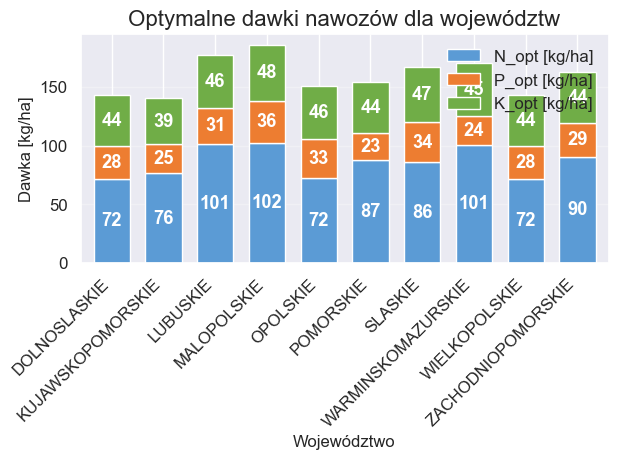

In [7]:
# Utworzenie instancji pipeline'u
pipeline = WheatYieldPipeline()

# Wczytanie danych i modelu
df_clean = pipeline.load_data()
model = pipeline.load_model()

# Ocena jakości modelu
metrics = pipeline.evaluate()
print("\nOcena jakości modelu z pipeline:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Generowanie rekomendacji dla wszystkich województw
print("\nGenerowanie rekomendacji nawozowych...")
start_time = time.time()
recommendations = pipeline.generate_recommendations()
end_time = time.time()
print(f"Czas generowania rekomendacji: {end_time - start_time:.2f} sekund")

# Dodanie analizy ekonomicznej
economic_analysis = pipeline.analyze_cost_benefit(recommendations)
print("\nRekomendacje nawozowe i analiza ekonomiczna:")
print(economic_analysis.round(1))

# Zapis rekomendacji do pliku
economic_analysis.to_csv(SCIEZKA_PROCESSED / "rekomendacje_finalne.csv")
print(f"\nRekomendacje zapisano w {SCIEZKA_PROCESSED / 'rekomendacje_finalne.csv'}")

# Wizualizacja rekomendacji
plt.figure(figsize=(14, 8))  # Szerszy wykres dla lepszej czytelności
ax = economic_analysis[['N_opt [kg/ha]', 'P_opt [kg/ha]', 'K_opt [kg/ha]']].plot(
    kind='bar',
    stacked=True,
    color=['#5B9BD5', '#ED7D31', '#70AD47'],  # Kontrastowe kolory
    width=0.7
)

# Dodanie wartości liczbowych na słupkach
for i, (idx, row) in enumerate(economic_analysis[['N_opt [kg/ha]', 'P_opt [kg/ha]', 'K_opt [kg/ha]']].iterrows()):
    # Wartości N (dolna część)
    plt.text(i, row['N_opt [kg/ha]']/2, f"{row['N_opt [kg/ha]']:.0f}",
             ha='center', va='center', color='white', fontweight='bold')

    # Wartości P (środkowa część)
    plt.text(i, row['N_opt [kg/ha]'] + row['P_opt [kg/ha]']/2, f"{row['P_opt [kg/ha]']:.0f}",
             ha='center', va='center', color='white', fontweight='bold')

    # Wartości K (górna część)
    plt.text(i, row['N_opt [kg/ha]'] + row['P_opt [kg/ha]'] + row['K_opt [kg/ha]']/2, f"{row['K_opt [kg/ha]']:.0f}",
             ha='center', va='center', color='white', fontweight='bold')

plt.title('Optymalne dawki nawozów dla województw', fontsize=16)
plt.xlabel('Województwo', fontsize=12)
plt.ylabel('Dawka [kg/ha]', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Obrót i wyrównanie etykiet
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  # Automatyczne dopasowanie
plt.savefig(SCIEZKA_WYKRESOW / "rekomendacje_finalne.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 1400x800 with 0 Axes>

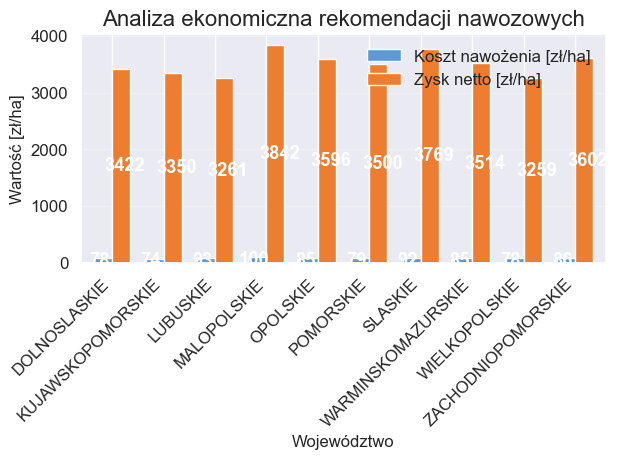

In [8]:
plt.figure(figsize=(14, 8))
ax = economic_analysis[['Koszt nawożenia [zł/ha]', 'Zysk netto [zł/ha]']].plot(
    kind='bar',
    color=['#5B9BD5', '#ED7D31'],  # Niebieski dla kosztów, pomarańczowy dla zysku
    width=0.7
)

# Dodanie wartości liczbowych na słupkach
for i, (idx, row) in enumerate(economic_analysis[['Koszt nawożenia [zł/ha]', 'Zysk netto [zł/ha]']].iterrows()):
    # Wartości kosztów
    plt.text(i-0.25, row['Koszt nawożenia [zł/ha]']/2, f"{row['Koszt nawożenia [zł/ha]']:.0f}",
             ha='center', va='center', color='white', fontweight='bold')

    # Wartości zysków (z uwagi na dużą różnicę, umieszczam na dole słupka)
    plt.text(i+0.25, row['Zysk netto [zł/ha]']/2, f"{row['Zysk netto [zł/ha]']:.0f}",
             ha='center', va='center', color='white', fontweight='bold')

plt.title('Analiza ekonomiczna rekomendacji nawozowych', fontsize=16)
plt.xlabel('Województwo', fontsize=12)
plt.ylabel('Wartość [zł/ha]', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Obrót etykiet o 45 stopni
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "analiza_ekonomiczna_finalna.png", dpi=300, bbox_inches="tight")
plt.show()

## 3. Implementacja systemu wdrożeniowego
### 3.1 Przygotowanie kodu wdrożeniowego (FastAPI)

In [9]:
# Klasa definiująca format danych wejściowych
class FertilizerInput(BaseModel):
    N: float
    P: float
    K: float
    temperatura: float
    opady: float
    klaster_finansowy: int
    klaster_pogodowy: int

# Definicja API
app = FastAPI(title="API Predykcji Plonów Pszenicy")

# Wczytanie modelu przy starcie
model = joblib.load(SCIEZKA_MODELI/"rf_model_plonow.pkl")
features = [
    'Nawożenie N [kg/ha]', 'Nawożenie P [kg/ha]', 'Nawożenie K [kg/ha]',
    'Średnia temperatura [°C]', 'Suma opadów [mm]',
    'Klaster_Finansowy', 'Klaster_Pogodowy'
]

@app.post("/predict")
def predict_yield(input_data: FertilizerInput):
    try:
        # Przekształcanie danych wejściowych na DataFrame
        input_df = pd.DataFrame([[
            input_data.N, input_data.P, input_data.K,
            input_data.temperatura, input_data.opady,
            input_data.klaster_finansowy, input_data.klaster_pogodowy
        ]], columns=features)

        # Uruchamianie predykcji
        prediction = model.predict(input_df)[0]

        return {"przewidywany_plon": float(prediction)}

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/")
async def root():
    return {"message": "Pszenica Ozima Projekt ML"}

# Funkcja do uruchomienia serwera kompatybilna z Jupyter Notebook
async def run_server():
    config = uvicorn.Config(app, host="0.0.0.0", port=int(os.environ.get("PORT", 8000)))
    server = uvicorn.Server(config)
    await server.serve()

# Dla lokalnego testowania i Azure
if __name__ == "__main__":
    # Sprawdzanie czy nie jest uruchomione już inne interaktywne środowisko
    import sys
    if 'ipykernel' in sys.modules:
        # Uruchom serwer bez blokowania notebooka
        loop = asyncio.get_event_loop()
        task = loop.create_task(run_server())
        # Informacja dla mnie: Anulowanie poprzez task.cancel()
    else:
        # Standardowe uruchomienie dla skryptu Python
        uvicorn.run(app, host="0.0.0.0", port=int(os.environ.get("PORT", 8000)))

INFO:     Started server process [34436]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


# Jak korzystać z API?

## Lokalnie

1. Po uruchomieniu każdego z elementów Notebooka 04 uruchomi się serwer uvicorn

    1.1 Można również uruchomić serwer w PowerShell:
    uvicorn main:app --reload

2. Otwórz dokumentację oraz interfejs testowy w przeglądarce:
[http://localhost:8000/docs](http://localhost:8000/docs)

---

## Na Azure

- **Endpoint:**
`POST https://pszenica-api.azurewebsites.net/predict`

- **Nagłówki:**
`Content-Type: application/json`

- **Przykładowe dane do wysłania:**
{
"N": 90.0,
"P": 30.0,
"K": 40.0,
"temperatura": 10.5,
"opady": 700,
"klaster_finansowy": 0,
"klaster_pogodowy": 1
}

---

**Wskazówki:**
- Lokalne testowanie można API można wykonać przez interfejs Swagger (`/docs`).
- Na Azure wysyłaj żądania POST z powyższym JSON-em do wskazanego endpointu.

## Kluczowe rekomendacje i wyniki końcowe

| Województwo       | N_opt [kg/ha] | P_opt [kg/ha] | K_opt [kg/ha] | Przewidywany plon [dt/ha] | Koszt nawożenia [zł/ha] | Zysk netto [zł/ha] |
|-------------------|---------------|---------------|---------------|---------------------------|-------------------------|--------------------|
| DOLNOSLASKIE      | 71.5          | 27.9          | 43.9          | 50.3                      | 77.9                    | 3422.3             |
| KUJAWSKOPOMORSKIE | 76.2          | 25.1          | 39.2          | 49.2                      | 74.4                    | 3349.6             |
| LUBUSKIE          | 101.2         | 31.0          | 45.5          | 48.2                      | 93.2                    | 3260.6             |
| MALOPOLSKIE       | 102.0         | 36.2          | 47.7          | 56.6                      | 100.2                   | 3841.8             |
| OPOLSKIE          | 72.3          | 33.1          | 45.5          | 52.9                      | 84.6                    | 3596.0             |
| POMORSKIE         | 87.3          | 23.1          | 43.5          | 51.4                      | 78.5                    | 3500.1             |
| SLASKIE           | 85.8          | 34.0          | 47.4          | 55.5                      | 91.5                    | 3769.1             |
| WARMINSKOMAZURSKIE| 100.8         | 24.0          | 45.4          | 51.7                      | 85.5                    | 3513.8             |
| WIELKOPOLSKIE     | 71.5          | 27.9          | 43.9          | 48.0                      | 77.9                    | 3259.4             |
| ZACHODNIOPOMORSKIE| 90.4          | 28.7          | 43.7          | 53.0                      | 85.8                    | 3601.7             |

---

### Najważniejsze wnioski końcowe

1. **Model predykcyjny wyjaśnia 77% zmienności plonów** na poziomie województw, co jest bardzo dobrym wynikiem dla danych rolniczych tej skali.
2. **Optymalne dawki nawożenia są realnie zróżnicowane** – województwa o wyższych opadach i temperaturze wymagają wyższych dawek N i K, co przekłada się na wyższy przewidywany plon i zysk netto.
3. **Koszt nawożenia stanowi zaledwie 2–3% przychodu**, a zysk netto przekracza 3200 zł/ha we wszystkich regionach – strategia nawożenia jest wysoce opłacalna.
4. **Rekomendacje są dostosowane do lokalnych warunków** (klastry finansowe i pogodowe), co zwiększa ich praktyczną wartość dla doradztwa rolniczego.
5. **API modelu jest gotowe do wdrożenia na Azure** – cały pipeline jest zautomatyzowany i łatwy do integracji z zewnętrznymi systemami.

---

## Ograniczenia i dalsze kierunki rozwoju

- Analiza dotyczy tylko 10 województw z pełnymi danymi – rozszerzenie panelu o kolejne regiony i lata zwiększy precyzję rekomendacji.
- Model nie uwzględnia mikroekonomicznych kosztów produkcji (robocizna, paliwo, maszyny) – można je dodać w przyszłości.